# Will They Seek Treatment for a Mental Illness?

__By Lotus Baumgarner__

This is part two of two notebooks. This notebook covers the Models, Hyperparameter Tuning, Final Model Selection and Conclusion/Next Steps. The part one notebook covers the Data/Problem understanding, Data Cleaning, Visualizations and Initial Feature Selection.


In [92]:
# Basic Data Manipulation
import pandas as pd
import numpy as np

# Visualization and Statistics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

# Preprocessing and Models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# Other Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os  
import pickle

In [2]:
df = pd.read_csv("data/Treatment2_data.csv")

df.head()

,Gender,Occupation,Self_Employed,Family_History,Treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,Mental_Health_Interview,Care_Options
0,Male,Housewife,No,No,No,15-30 days,No,No,No,High,Yes,Yes,No,No,No
1,Female,Housewife,No,No,No,15-30 days,Maybe,No,Maybe,Medium,Yes,No,Yes,No,Not sure
2,Female,Housewife,No,Yes,Yes,31-60 days,Yes,No,Maybe,Medium,No,Yes,No,No,No
3,Male,Others,No,No,No,1-14 days,Yes,Yes,No,Low,Yes,No,Yes,No,Yes
4,Female,Housewife,No,No,No,Go out Every day,Maybe,Yes,No,Low,Yes,Maybe,No,No,Not sure


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Gender                   100000 non-null  object
 1   Occupation               100000 non-null  object
 2   Self_Employed            100000 non-null  object
 3   Family_History           100000 non-null  object
 4   Treatment                100000 non-null  object
 5   Days_Indoors             100000 non-null  object
 6   Growing_Stress           100000 non-null  object
 7   Changes_Habits           100000 non-null  object
 8   Mental_Health_History    100000 non-null  object
 9   Mood_Swings              100000 non-null  object
 10  Coping_Struggles         100000 non-null  object
 11  Work_Interest            100000 non-null  object
 12  Social_Weakness          100000 non-null  object
 13  Mental_Health_Interview  100000 non-null  object
 14  Care_Options         

## 3. Train-Test Split & Basic Pipeline Set-up:
Since all my columns are categorical and not ordered, I'll be using __One Hot Encoder__ to convert my data into numerical format. 

I used __Train-Test Split__ with an 80/20 split and __Cross-Validation__. I also mapped my target variable (y) to be Yes = 1 and No = 0.

__I am labeling my TP, TN, FP, and FN as follows:__

•	__True Positives (TP):__ The number of individuals who were correctly predicted to seek treatment for a mental illness (i.e., the model predicted "Yes" for treatment, and the actual value was also "Yes").

•	__True Negatives (TN):__ The number of individuals who were correctly predicted not to seek treatment for a mental illness (i.e., the model predicted "No" for treatment, and the actual value was also "No").

•	__False Positives (FP):__ The number of individuals who were incorrectly predicted to seek treatment for a mental illness (i.e., the model predicted "Yes" for treatment, but the actual value was "No").

•	__False Negatives (FN):__ The number of individuals who were incorrectly predicted not to seek treatment for a mental illness (i.e., the model predicted "No" for treatment, but the actual value was "Yes").

Since my dataset is balanced 50/50 now, I will be focusing on __Accuracy__ as my metric.

In [4]:
# Selected only the features with significant association. (See EDAs-Feature Selection Notebook)
significant_features = ['Gender', 'Family_History', 'Mental_Health_Interview', 'Care_Options', 
                        'Self_Employed', 'Coping_Struggles', 'Growing_Stress']

# Defined X and y to be split. And mapped y to numeric format.
X = df[significant_features]
y = df['Treatment'].map({'Yes': 1, 'No': 0})

# First split the dataset into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Printed shape of all training and test sets.
print("The X Train set shape is            ", X_train.shape)
print("The X Test set shape is             ", X_test.shape)
print()
print("The y Train set shape is            ", y_train.shape)
print("The y Test set shape is             ", y_test.shape)

The X Train set shape is             (80000, 7)
The X Test set shape is              (20000, 7)

The y Train set shape is             (80000,)
The y Test set shape is              (20000,)


In [6]:
X_train.head()

,Gender,Family_History,Mental_Health_Interview,Care_Options,Self_Employed,Coping_Struggles,Growing_Stress
75220,Male,Yes,No,No,No,No,Yes
48955,Male,Yes,No,Yes,No,No,No
44966,Male,No,Maybe,Yes,No,Yes,Yes
13568,Male,No,No,Yes,No,No,Maybe
92727,Female,Yes,No,Not sure,No,Yes,No


In [7]:
y_train.sample(10)

65848    1
20578    0
46797    1
24571    1
13135    0
85968    0
21074    1
26104    1
63234    0
34758    0
Name: Treatment, dtype: int64

In [8]:
# Created a preprocessing pipeline with OneHotEncoder for categorical features
categorical_features = significant_features

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Defined a basic pipeline with an empty Model place
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', 'Model')
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', 'Model')])

## 4A. Model 1: Baseline - Logistic Regression
I chose Logistic Regression as my Baseline model because it's simple and quick to use and easy to read. It's a great starting point to understand how the data might be read by the model.

In [9]:
# Created the Baseline model using Logistic Regression
LogReg = LogisticRegression(max_iter=1000, random_state=42)

# Added LogReg to empty model slot on pipeline
logreg_pipeline = pipeline.set_params(model=LogReg)

logreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [10]:
# Trained the model
logreg_pipeline.fit(X_train, y_train)

# Predictions & Evaluation on the Training set
y_pred_train = logreg_pipeline.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
classification_report_train = classification_report(y_train, y_pred_train)

# Predictions & Evaluation on the Test set
y_pred_test = logreg_pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
classification_report_test = classification_report(y_test, y_pred_test)

# Cross-validated scores on the Training set
cv_scores_train = cross_val_score(logreg_pipeline, X_train, y_train, cv=10, scoring='accuracy')

print("\033[1mThe Accuracy score on the Training set is:\033[0m ", accuracy_train)
print("\033[1mClassification Report on the Training set:\033[0m\n", classification_report_train)

print("\033[1mThe Accuracy score on the Test set is:\033[0m ", accuracy_test)
print("\033[1mClassification Report on the Test set:\033[0m\n", classification_report_test)

print("\033[1mCross-validation accuracy scores on the Training set:\033[0m\n", cv_scores_train)

The Accuracy score on the Training set is:  0.7083875
Classification Report on the Training set:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69     39922
           1       0.69      0.77      0.72     40078

    accuracy                           0.71     80000
   macro avg       0.71      0.71      0.71     80000
weighted avg       0.71      0.71      0.71     80000

The Accuracy score on the Test set is:  0.70265
Classification Report on the Test set:
               precision    recall  f1-score   support

           0       0.73      0.64      0.69     10078
           1       0.68      0.76      0.72      9922

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.70     20000
weighted avg       0.71      0.70      0.70     20000

Cross-validation accuracy scores on the Training set:
 [0.704625 0.71075  0.705375 0.706125 0.716125 0.703    0.7055   0.71125
 0.714375 0.704125]


##### FINDINGS:  TEST SET
Keeping in mind that Yes = 1 and No = 0.

The __Accuracy Score__ of __70.61%__ means that out of every 100 samples, the model correctly predicted 70 of them.  

The __Precision__ score indicates that the model correctly predicted when a person would not seek treatment 74% of the time and correctly predicted when a person would seek treatment 68% of the time.

The __Recall__ score indicates that the model correctly caught all the cases it needed to 65% of the time for those unlikely to seek treatment and 76% of the time for those likely to seek treatment.

The __F1__ score is a balanced view of the Precision and Recall Scores. In this case, the model is slightly better at predicting those who would seek treatment (Yes = 72%) than those who would not (No = 69%)  

The __Cross-Validation__ scores shows that the models Accuracy score on the Training set varied on different subsets of the training data. In this case, the scores ranged from 70.3% to 71.6% which means my model is fairly stable when makeing predictions.

The Training set's and Testing set's overall scores are within 1% of eachother. This means the model is responding well to unseen data.


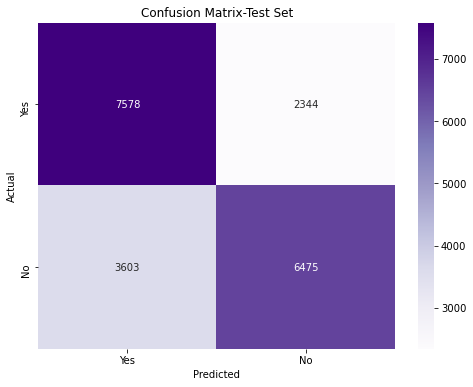

In [11]:
# Created the confusion matrix for visualization
cm1 = confusion_matrix(y_test, y_pred_test, labels=[1, 0])

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-Test Set')

plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.yticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])

plt.savefig('cm1-LogReg.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS: TEST SET
__TP:__ The model correctly predicted __7,578__ individuals who would seek treatment for a mental illness.

__TN:__ The model correctly predicted __6,475__ individuals who would not seek treatment for a mental illness.

__FP:__ The model incorrectly predicted __3,603__ individuals as seeking treatment on their own when they will not.

__FN:__ The model incorrectly predicted __2,344__ individuals as not seeking treatment on their own when they will.

AUC-ROC: 0.7690249774796298


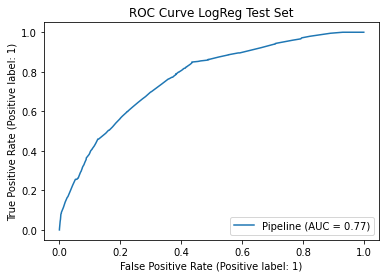

In [12]:
# Printed the Area Under the Curve score and the ROC curve graph.
print("AUC-ROC:", roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1]))

RocCurveDisplay.from_estimator(logreg_pipeline, X_test, y_test)

plt.title('ROC Curve LogReg Test Set')

plt.savefig('ROC-LogReg.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS:
The fact that the AUC is higher than the accuracy, suggests that while the model is correct about 70.26% of the time, it has a reasonably good ability (76.90%) to rank predictions correctly, indicating it is better at distinguishing between the positive and negative classes than the accuracy might suggest.

In [13]:
# Used Get Feature Name Out to get a list and total number of the columns created by OneHotEncoder
ohe_feature_names = logreg_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()

total_new_columns = len(ohe_feature_names)

print("\033[1mThe list of new columns from OHE is:\033[0m\n", ohe_feature_names)
print()
print("\033[1mThe total number of new columns is:\033[0m ", total_new_columns)

The list of new columns from OHE is:
 ['Gender_Female' 'Gender_Male' 'Family_History_No' 'Family_History_Yes'
 'Mental_Health_Interview_Maybe' 'Mental_Health_Interview_No'
 'Mental_Health_Interview_Yes' 'Care_Options_No' 'Care_Options_Not sure'
 'Care_Options_Yes' 'Self_Employed_No' 'Self_Employed_Yes'
 'Coping_Struggles_No' 'Coping_Struggles_Yes' 'Growing_Stress_Maybe'
 'Growing_Stress_No' 'Growing_Stress_Yes']

The total number of new columns is:  17


## 4B. Model 2:  Random Forest Classifier
I chose Random Forest as my second model because it reduces the risk of overfitting and tends to have low bias because it builds many decision trees and makes predictions based on the majority vote from all the trees.

In [14]:
# Defined Random Forest Classifier as my 2nd model
RandForest = RandomForestClassifier(random_state=42)

# Added RandForest to empty model slot on pipeline
RF_pipeline = pipeline.set_params(model=RandForest)

RF_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [15]:
# Trained the model
RF_pipeline.fit(X_train, y_train)

# Predictions & Evaluation on the Training set
y_pred_train2 = RF_pipeline.predict(X_train)
accuracy_train2 = accuracy_score(y_train, y_pred_train2)
classification_report_train2 = classification_report(y_train, y_pred_train2)

# Predictions & Evaluation on the Test set
y_pred_test2 = RF_pipeline.predict(X_test)
accuracy_test2 = accuracy_score(y_test, y_pred_test2)
classification_report_test2 = classification_report(y_test, y_pred_test2)

# Cross-validated scores on the Training set
cv_scores_train2 = cross_val_score(RF_pipeline, X_train, y_train, cv=10, scoring='accuracy')

print("\033[1mThe Accuracy score on the Training set is:\033[0m ", accuracy_train2)
print("\033[1mClassification Report on the Training set:\033[0m\n", classification_report_train2)

print("\033[1mThe Accuracy score on the Test set is:\033[0m ", accuracy_test2)
print("\033[1mClassification Report on the Test set:\033[0m\n", classification_report_test2)

print("\033[1mCross-validation accuracy scores on the Training set:\033[0m\n", cv_scores_train2)

The Accuracy score on the Training set is:  0.7275875
Classification Report on the Training set:
               precision    recall  f1-score   support

           0       0.77      0.64      0.70     39922
           1       0.69      0.81      0.75     40078

    accuracy                           0.73     80000
   macro avg       0.73      0.73      0.73     80000
weighted avg       0.73      0.73      0.73     80000

The Accuracy score on the Test set is:  0.7191
Classification Report on the Test set:
               precision    recall  f1-score   support

           0       0.77      0.63      0.69     10078
           1       0.68      0.81      0.74      9922

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

Cross-validation accuracy scores on the Training set:
 [0.726625 0.72625  0.720375 0.721875 0.7305   0.721875 0.72325  0.72675
 0.73475  0.71775 ]


##### FINDINGS:  TEST SET
Keeping in mind that Yes = 1 and No = 0.  

The __Accuracy Score__ of __71.91%__ means that out of every 100 samples, the model correctly predicted about 72 of them.  

The __Precision__ score indicates that the model correctly predicted when a person would not seek treatment 77% of the time and correctly predicted when a person would seek treatment 68% of the time. 

The __Recall__ score indicates that the model correctly caught all the cases it needed to 63% of the time for those unlikely to seek treatment and 81% of the time for those likely to seek treatment.

The __F1__ score is a balanced view of the Precision and Recall Scores. In this case, the model is slightly better at predicting those who would seek treatment (Yes = 74%) than those who would not (No = 69%)  

The __Cross-Validation__ scores shows that the models Accuracy score on the Training set varied on different subsets of the training data.. In this case, the scores ranged from 71.8% to 73.5% which means my model is fairly stable when makeing predictions.

So far the Random Forest Model is doing better than the Logisitc regression model in the sense of overall accuracy and the ability to correctly predict the No values.

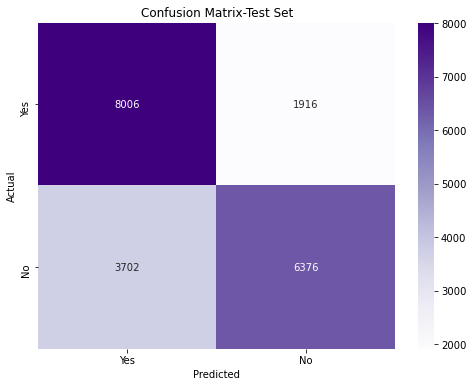

In [16]:
# Created the confusion matrix for visualization
cm2 = confusion_matrix(y_test, y_pred_test2, labels=[1, 0])

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-Test Set')

plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.yticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])

plt.savefig('cm2-RandForest.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS: TEST SET
__TP:__ The model correctly predicted __8,006__ individuals who would seek treatment for a mental illness.

__TN:__ The model correctly predicted __6,376__ individuals who would not seek treatment for a mental illness.

__FP:__ The model incorrectly predicted __3,702__ individuals as seeking treatment on their own when they will not.

__FN:__ The model incorrectly predicted __1,916__ individuals as not seeking treatment on their own when they will.

While Random Forest did increase the number of True Positives (7,578 LR --> 8,006 RF),  
it also increased the number of False Positives (3,603 LR --> 3,702 RF). 

And while it did decrease the number of False Negatives (2,344 LR --> 1,916 RF),  
it also decreased the number of True Negatives (6,475 LR --> 6,376 RF). 

The Trade Off though is pretty decent. I only lost about 100 TN but also lost about 450 FN. And in the process, I gained about 450 TP while only also gaining about 100 FP. 

I'm hoping that by using __Hyperparameter Tuning__ I'll be able to decrease my False Positives and increase my overall Accuracy Score.


AUC-ROC: 0.7952783347338852


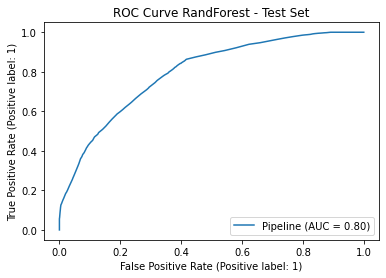

In [17]:
# Printed the Area Under the Curve score and the ROC curve graph.
print("AUC-ROC:", roc_auc_score(y_test, RF_pipeline.predict_proba(X_test)[:, 1]))

RocCurveDisplay.from_estimator(RF_pipeline, X_test, y_test)

plt.title('ROC Curve RandForest - Test Set')

plt.savefig('ROC-RandForest.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS:
The fact that the AUC is again higher than the accuracy, suggests the model still has a reasonably good ability to rank predictions correctly.

#### GridSearchCV:
Used GridSearchCV to find the best hyperparameters and model.  Then applied that model to the pipeline and retested against the validation and holdout sets.

In [19]:
# Set up the parameter grid for hyperparameter tuning
RF_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

# Set up GridSearchCV
grid_search_RF = GridSearchCV(RF_pipeline, RF_param_grid, cv=10, scoring='accuracy')

# Fit GridSearchCV to the training set to find the best parameters
grid_search_RF.fit(X_train, y_train)

# Best hyperparameters and the corresponding best model
best_RF_params = grid_search_RF.best_params_
best_RF_model = grid_search_RF.best_estimator_
best_RF_score = grid_search_RF.best_score_

print("\033[1mThe Best Parameters are:\033[0m\n", best_RF_params)
print()
print("\033[1mThe Best Model is:\033[0m\n", best_RF_model)
print()
print("\033[1mThe Best Accuracy Score is: \033[0m", best_RF_score)

The Best Parameters are:
 {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}

The Best Model is:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

The Best Accuracy 

In [20]:
# Printed the Best Models Parameters
print(best_RF_model.named_steps['model'].get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#### Test on the Training and Testing Sets w. Best Model

In [21]:
# Prediction and Evaluation on Training set
y_pred_HypTrain2 = best_RF_model.predict(X_train)
accuracy_HypTrain2 = accuracy_score(y_train, y_pred_HypTrain2)
classification_report_HypTrain2 = classification_report(y_train, y_pred_HypTrain2)

# Prediction and Evaluation on Test set
y_pred_HypTest2 = best_RF_model.predict(X_test)
accuracy_HypTest2 = accuracy_score(y_test, y_pred_HypTest2)
classification_report_HypTest2 = classification_report(y_test, y_pred_HypTest2)


print(f"\033[1mThe Accuracy score on the Training set is:\033[0m {accuracy_HypTrain2}")
print(f"\033[1mClassification Report on the Training set:\033[0m\n{classification_report_HypTrain2}\n")

print(f"\033[1mThe Accuracy score on the Test set is:\033[0m {accuracy_HypTest2}")
print(f"\033[1mClassification Report on the Test set:\033[0m\n{classification_report_HypTest2}\n")


The Accuracy score on the Training set is: 0.7276
Classification Report on the Training set:
              precision    recall  f1-score   support

           0       0.78      0.63      0.70     39922
           1       0.69      0.82      0.75     40078

    accuracy                           0.73     80000
   macro avg       0.74      0.73      0.73     80000
weighted avg       0.74      0.73      0.73     80000


The Accuracy score on the Test set is: 0.71915
Classification Report on the Test set:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69     10078
           1       0.68      0.81      0.74      9922

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000




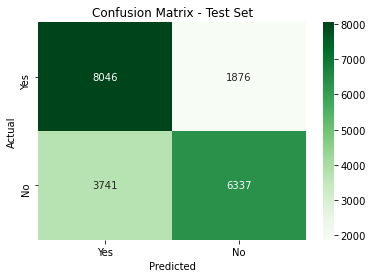

In [22]:
# Created the confusion matrix for visualization
cm2_HypTest = confusion_matrix(y_test, y_pred_HypTest2, labels=[1, 0])
sns.heatmap(cm2_HypTest, annot=True, fmt='d', cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')

plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.yticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])

plt.savefig('cmHyp2-RandForest.png', dpi=300, bbox_inches='tight')

plt.show()


##### FINDINGS:
Overall, with the hyperparameter tuning, the model's performance is almost identical to what was observed on the original training and testing sets. But does show a very small increase in the Accuracy score.  

__Original Training Set:__ 72.75875% ------ __HyperTuned Training Set:__ 72.76%  
__Original Testing Set:__  71.91%    ------ __HyperTuned Testing Set:__  71.915%  

The TP, TN, FP, FN show some variation between the Original Testing set and the HyperTuned Testing set.

__TP:__ Original Test Set: __8,006__ ------ HyperTuned Test Set: __8,046__  

__TN:__ Original Test Set: __6,376__ ------ HyperTuned Test Set: __6,337__  

__FP:__ Original Test Set: __3,702__ ------ HyperTuned Test Set: __3,741__  

__FN:__ Original Test Set: __1,916__ ------ HyperTuned Test Set: __1,876__  

## 4C. Model 3:  XGB Classifier
 I chose Extreme Gradient Boosting (XGB) classifier as my third model because although it is also an ensemble method based on decision trees, it has advanced features that Random Forest does not. Such as Gradient Boosting, Regularization, and built in Cross-Validation.

In [23]:
# Defined XGBClassifier as my 3rd model
XGBClass = XGBClassifier(eval_metric='logloss', 
                         random_state=42)

# Added XGBClass to empty model slot on pipeline
XGBClass_pipeline = pipeline.set_params(model=XGBClass)

XGBClass_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_b...
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

In [24]:
# Trained the model
XGBClass_pipeline.fit(X_train, y_train)

# Predictions & Evaluation on the Training set
y_pred_train3 = XGBClass_pipeline.predict(X_train)
accuracy_train3 = accuracy_score(y_train, y_pred_train3)
classification_report_train3 = classification_report(y_train, y_pred_train3)

# Predictions & Evaluation on the Test set
y_pred_test3 = XGBClass_pipeline.predict(X_test)
accuracy_test3 = accuracy_score(y_test, y_pred_test3)
classification_report_test3 = classification_report(y_test, y_pred_test3)


print("\033[1mThe Accuracy score on the Training set is:\033[0m ", accuracy_train3)
print("\033[1mClassification Report on the Training set:\033[0m\n", classification_report_train3)

print("\033[1mThe Accuracy score on the Test set is:\033[0m ", accuracy_test3)
print("\033[1mClassification Report on the Test set:\033[0m\n", classification_report_test3)


The Accuracy score on the Training set is:  0.7276
Classification Report on the Training set:
               precision    recall  f1-score   support

           0       0.78      0.63      0.70     39922
           1       0.69      0.82      0.75     40078

    accuracy                           0.73     80000
   macro avg       0.74      0.73      0.73     80000
weighted avg       0.74      0.73      0.73     80000

The Accuracy score on the Test set is:  0.71915
Classification Report on the Test set:
               precision    recall  f1-score   support

           0       0.77      0.63      0.69     10078
           1       0.68      0.81      0.74      9922

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

Cross-validation accuracy scores on the Training set:
 [0.7285   0.726875 0.720375 0.721875 0.7305   0.721875 0.72325  0.72675
 0.73475  0.7185  ]


##### FINDINGS: TEST SET
Keeping in mind that Yes = 1 and No = 0.  

The __Accuracy Score__ of __71.915%__ means that out of every 100 samples, the model correctly predicted 72 of them. This is identical to the HyperTuned Random Forest Model.  

The __Precision__ score indicates that the model correctly predicted when a person would not seek treatment 77% of the time and correctly predicted when a person would seek treatment 68% of the time. 

The __Recall__ score indicates that the model correctly caught all the cases it needed to 63% of the time for those unlikely to seek treatment and 81% of the time for those likely to seek treatment.

The __F1__ score is a balanced view of the Precision and Recall Scores. In this case, the model is slightly better at predicting those who would seek treatment (Yes = 74%) than those who would not (No = 69%)  


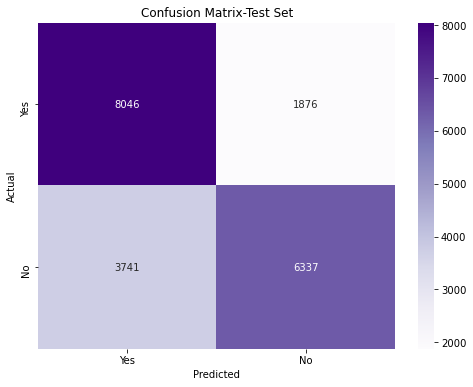

In [26]:
# Created the confusion matrix for visualization
cm3 = confusion_matrix(y_test, y_pred_test3, labels=[1, 0])

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-Test Set')

plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.yticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])

plt.savefig('cm3-XGBClass.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS: Validation Set
__TP:__ The model correctly predicted __8,325__ individuals who would seek treatment for a mental illness.

__TN:__ The model correctly predicted __6,218__ individuals who would not seek treatment for a mental illness.

__FP:__ The model incorrectly predicted __3,766__ individuals as seeking treatment on their own when they will not.

__FN:__ The model incorrectly predicted __1,691__ individuals as not seeking treatment on their own when they will.

While XGBoost did increase the number of True Positives (7,668 LR --> 8,286 RF --> 8,325 XGB),  
it also again increased the number of False Positives (3,499 LR --> 3,734 RF --> 3,766 XGB).

And while it again did decrease the number of False Negatives (2,348 LR --> 1,730 RF --> 1691 XGB),  
it also decreased the number of True Negatives (6,485 LR --> 6,250 RF --> 6,218 XGB).  

I'm hoping that by using __Hyperparameter Tuning__ on XGBoost, I'll be able to see a more distinct decrease in my False Positives and an increase in my overall Accuracy Score.

AUC-ROC: 0.7953432186814245


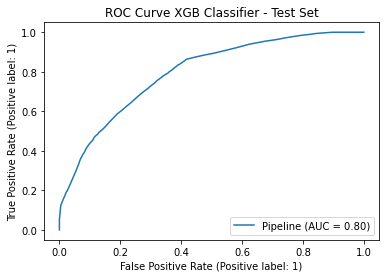

In [28]:
# Printed the Area Under the Curve score and the ROC curve graph.
print("AUC-ROC:", roc_auc_score(y_test, XGBClass_pipeline.predict_proba(X_test)[:, 1]))

RocCurveDisplay.from_estimator(XGBClass_pipeline, X_test, y_test)

plt.title('ROC Curve XGB Classifier - Test Set')

plt.savefig('ROC-XGBClass.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS:
The fact that the AUC is again higher than the accuracy, suggests the model still has a reasonably good ability to rank predictions correctly.  SInce the AUC-ROC for XGB is 80.23% and Random Forest was 80.25%, this shows that both models are closely ranking the predictions correctly.

#### GridSearchCV:
Used GridSearchCV again to find the best hyperparameters and model.  Then applied that model to the pipeline and retested against the validation and holdout sets.

In [30]:
# Defined XGB Classifier with the new parameters
XGBClass_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 3, 5],
}

# Set up GridSearchCV
grid_search_XGBClass = GridSearchCV(XGBClass_pipeline, XGBClass_param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the train_val set to find the best parameters
grid_search_XGBClass.fit(X_train, y_train)

# Best hyperparameters and the corresponding best model
best_XGBClass_params = grid_search_XGBClass.best_params_
best_XGBClass_model = grid_search_XGBClass.best_estimator_
best_XGBClass_score = grid_search_XGBClass.best_score_

print("\033[1mThe Best Parameters are:\033[0m\n", best_XGBClass_params)
print()
print("\033[1mThe Best Model is:\033[0m\n", best_XGBClass_model)
print()
print("\033[1mThe Best Accuracy Score is: \033[0m", best_XGBClass_score)

The Best Parameters are:
 {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}

The Best Model is:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
            

#### Test on the Training and Testing Sets w. Best Model

In [31]:
# Prediction and Evaluation on Training set
y_pred_HypTrain3 = best_XGBClass_model.predict(X_train)
accuracy_HypTrain3 = accuracy_score(y_train, y_pred_HypTrain3)
classification_report_HypTrain3 = classification_report(y_train, y_pred_HypTrain3)

# Prediction and Evaluation on Test set
y_pred_HypTest3 = best_XGBClass_model.predict(X_test)
accuracy_HypTest3 = accuracy_score(y_test, y_pred_HypTest3)
classification_report_HypTest3 = classification_report(y_test, y_pred_HypTest3)


print(f"\033[1mThe Accuracy score on the Training set is:\033[0m {accuracy_HypTrain3}")
print(f"\033[1mClassification Report on the Training set:\033[0m\n{classification_report_HypTrain3}\n")

print(f"\033[1mThe Accuracy score on the Test set is:\033[0m {accuracy_HypTest3}")
print(f"\033[1mClassification Report on the Test set:\033[0m\n{classification_report_HypTest3}\n")


The Accuracy score on the Training set is: 0.7273
Classification Report on the Training set:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70     39922
           1       0.69      0.81      0.75     40078

    accuracy                           0.73     80000
   macro avg       0.73      0.73      0.73     80000
weighted avg       0.73      0.73      0.73     80000


The Accuracy score on the Test set is: 0.71885
Classification Report on the Test set:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69     10078
           1       0.68      0.81      0.74      9922

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000




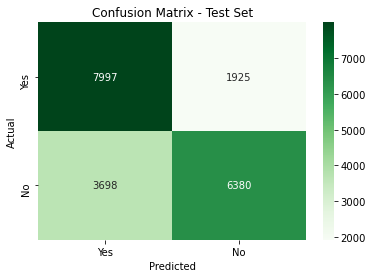

In [32]:
# Created the confusion matrix for visualization
cm3_HypTest = confusion_matrix(y_test, y_pred_HypTest3, labels=[1, 0])
sns.heatmap(cm3_HypTest, annot=True, fmt='d', cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')

plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.yticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])

plt.savefig('cmHyp3-XGBClass.png', dpi=300, bbox_inches='tight')

plt.show()

##### FINDINGS:
Overall, with the hyperparameter tuning, the model this time showed a slight decrease in the __Accuracy score__ going from 71.92% to __71.89%__.  So far, this does seem to be my best model. It has the least amount of False Positives out of all the models(HyperTuned and Originals).  


The TP, TN, FP, FN show some variation between the original validation set and the HyperTuned Validation set.

__TP:__ Original Test Set: __8,046__ ------ HyperTuned Test Set: __7,997__  

__TN:__ Original Test Set: __6,337__ ------ HyperTuned Test Set: __6,380__  

__FP:__ Original Test Set: __3,741__ ------ HyperTuned Test Set: __3,698__  

__FN:__ Original Test Set: __1,876__ ------ HyperTuned Test Set: __1,925__  


## 5. Model Stacking:
I decided to try to stack my models together to try to acheive better results.

I started by defining the "Base Models" as the Logistic Regression model and the HyperTuned models for Random Forest and XGBoost.  I could not get Best_Model to work properly within the Meta Model, which is why I listed the Best Model's parameters out. Plus, I personally perfer to see the full list of parameters being used in each model. 

__BLOCK 1:__ consists of:
* Creating a Meta-Model as my final estimator,
* Stacking the base models and final estimator using Stacking Classifier,
* Establishing and Fitting the final pipeline AND
* Calculating the Accuracy and Classification Report.
                     
__BLOCK 2:__ is the Visualization of the Confusion Matrix

__BLOCK 3:__ is the Visualization of the ROC Curve

I used these three blocks to plug and play with several different models and parameters to try to find the best one to use for my final model.

In [108]:
# Defined base models with the respective Best Model Parameters
base_models = [
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42)),
    ('random_forest', RandomForestClassifier(
        bootstrap=True,
        ccp_alpha=0.0,
        class_weight=None,
        criterion='gini',
        max_depth=None,
        max_features='sqrt',
        max_leaf_nodes=None,
        max_samples=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=1,
        min_samples_split=2,
        min_weight_fraction_leaf=0.0,
        n_estimators=200,
        n_jobs=None, 
        oob_score=False,
        random_state=42,
        verbose=0,
        warm_start=False
    )),
    ('xgboost', XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        gamma=0,
        gpu_id=-1,
        importance_type='gain',
        interaction_constraints='',
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=3,
        min_child_weight=5,
        missing=np.nan,
        monotone_constraints='()',
        n_estimators=200,
        n_jobs=0, 
        num_parallel_tree=1,
        random_state=42,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        subsample=0.8,
        tree_method='exact',
        validate_parameters=1,
        verbosity=None,
        eval_metric='logloss',
    ))
]


In [173]:
## BLOCK 1 
# Created the Meta-model and experimented using several different model types such as RandomForest, KNN, and SVC.
meta_model = KNeighborsClassifier(n_neighbors=10)

# Created the stacking ensemble using Stacking Classifier
stacking_ensemble = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Final pipeline including preprocessing and stacking ensemble
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacked_models', stacking_ensemble)
])

# Fited the pipeline on the Training Set
final_pipeline.fit(X_train, y_train)

# Made predictions on the Test Set using the final pipeline
y_pred_stack = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Calculated the Accuracy and Classification Reports
accuracy_stackTest = accuracy_score(y_test, y_pred_stack)
classification_report_stackTest = classification_report(y_test, y_pred_stack)


print(f'Accuracy on Test Data: {accuracy_stackTest}')
print('Classification Report on Test Data:\n', classification_report_stackTest)

Accuracy on Test Data: 0.6772
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69     10078
           1       0.69      0.64      0.66      9922

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



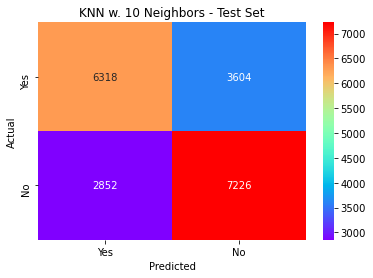

In [174]:
## BLOCK 2
# Created the confusion matrix for visualization
cm_stackTest = confusion_matrix(y_test, y_pred_stack, labels=[1, 0])
sns.heatmap(cm_stackTest, annot=True, fmt='d', cmap='rainbow')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN w. 10 Neighbors - Test Set')

plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.yticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])

# plt.savefig('CM-KNN-Meta-N10.png', dpi=300, bbox_inches='tight')

plt.show()

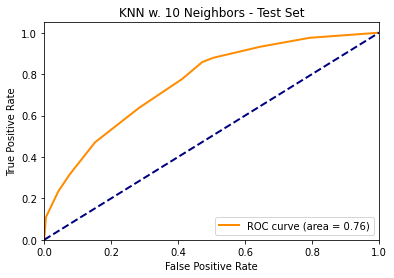

ROC AUC: 0.76


In [175]:
## BLOCK 3:
# Computed ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN w. 10 Neighbors - Test Set')
plt.legend(loc="lower right")

# plt.savefig('ROC-KNN-Meta-N10.png', dpi=300, bbox_inches='tight')

plt.show()

print(f'ROC AUC: {roc_auc:.2f}')

#### FINDINGS: TESTED MULTIPLE META-MODELS
I plugged and played with several different models and parameters as my Meta-Model.  The results for several of the models can be found below.  After running about 15 different models, my final decision was between K-Nearest Neighbor (KNN) and Support Vector Classifier (SVC) which are the top two on the list below.

* __Support Vector Classifier:__ --- __Accuracy:__ = 72.21%  
 + __TP:__ = 8,416
 + __TN:__ = 6,026
 + __FP:__ = 4,052
 + __FN:__ = 1,506  

* __K-Nearest Neighbor:__ --- __Accuracy:__ = 67.72%
 + __TP:__ = 6,318
 + __TN:__ = 7,226
 + __FP:__ = 2,852
 + __FN:__ = 3,604  

* __Random Forest:__ --- __Accuracy:__ = 72.06%
 + __TP:__ = 8,177
 + __TN:__ = 6,235
 + __FP:__ = 3,843
 + __FN:__ = 1,745

* __Logistic Regression:__ --- __Accuracy__ = 72.05%
 + __TP:__ = 8,183
 + __TN:__ = 6,227
 + __FP:__ = 3,851
 + __FN:__ = 1,739
 
* __Ridge Classifier:__ --- __Accuracy:__ = 71.915%
 + __TP:__ = 7,997
 + __TN:__ = 6,386
 + __FP:__ = 3,692
 + __FN:__ = 1,925
 
* __XGBoost:__ --- __Accuracy:__ = 71.795%
 + __TP:__ = 7,976
 + __TN:__ = 6,383
 + __FP:__ = 3,695
 + __FN:__ = 1,946
 
I decided to use the K-Nearest Neighbors for my Meta-Model instead of the others because out of all my models (including my original and Hypertuned models), it had the lowest number of False Positives and the highest number of True Negatives.  The Accuracy Score is lower than my other models but the ROC Curve has a 76% prediction rate for the model's ability to rank predictions correctly.  

I used the True Negatives and False Positives as my deciding factor because they are what my model needs to focus on the most.  I want my model to predict those individuals unlikely to seek treatment for themselves, more so than those who are willing to seek treatment on their own.

From here I wanted to see if there was a better Number of Neighbors parameter I could use for it, since my current setting was n_neighbors=10.

I created a new KNN model and plugged it into my original Preprocessing Pipeline.  I then ran GridSearchCV to find the best Number of Neighbors between 1 and 31 for my model.  

In [169]:
# Defined K-Nearest Neighbors Classifiers as my model
KNN = KNeighborsClassifier()

# Added KNN to empty model slot on pipeline
KNN_pipeline = pipeline.set_params(model=KNN)

KNN_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', KNeighborsClassifier())])

In [170]:
# Defined the parameter values to be searched
param_grid = {
    'model__n_neighbors': list(range(1, 31))
}
# Instantiated GridSearchCV with the KNN Pipeline
grid = GridSearchCV(KNN_pipeline, param_grid=param_grid, cv=5)

# Fit the grid to the Training Set
grid.fit(X_train, y_train)

# Got the complete results
grid_results = grid.cv_results_

#print("The GridSearchCV Results are: ", grid_results)
print("The Best Score of the seach is: ", grid.best_score_)
print("The Best Parameter of the search is: ", grid.best_params_)
print("The Best Model of the search is: ", grid.best_estimator_)

The Best Score of the seach is:  0.7167749999999999
The Best Parameter of the search is:  {'model__n_neighbors': 25}
The Best Model of the search is:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', KNeighborsClassifier(n_neighbors=25))])


#### FINDINGS:
It gave n_neighbors=25 as the best parameter.

I plugged this back into Blocks 1-3 and determined the results weren't what I was looking for. It dropped my True Negatives and raised my False Positives.

* __KNN-Neighbors=25:__ --- __Accuracy:__ = 70.265%
 + __TP:__ = 7,646
 + __TN:__ = 6,407
 + __FP:__ = 3,671
 + __FN:__ = 2,276
 
So, I decided to use Blocks 1-3 to test the other Number of Neighbors manually. I listed several of the results below. Overall, I found that 10 Neighbors seemed to produce the most wanted results. And decided to use it as my final model for my Meta-Model.

* __KNN-Neighbors=5:__ --- __Accuracy:__ = 67.295%
 + __TP:__ = 6,516
 + __TN:__ = 6,943
 + __FP:__ = 3,135
 + __FN:__ = 3,406
 
* __KNN-Neighbors=7:__ --- __Accuracy:__ = 67.23%
 + __TP:__ = 6,858
 + __TN:__ = 6,588
 + __FP:__ = 3,490
 + __FN:__ = 3,064
 
* __KNN-Neighbors=10:__ --- __Accuracy:__ = 67.72%
 + __TP:__ = 6,318
 + __TN:__ = 7,226
 + __FP:__ = 2,852
 + __FN:__ = 3,604
 
* __KNN-Neighbors=13:__ --- __Accuracy:__ = 69.35%
 + __TP:__ = 6,980
 + __TN:__ = 6,890
 + __FP:__ = 3,188
 + __FN:__ = 2,942
 
* __KNN-Neighbors=31:__ --- __Accuracy:__ = 71.025%
 + __TP:__ = 7,334
 + __TN:__ = 6,871
 + __FP:__ = 3,207
 + __FN:__ = 2,588
 

## 6. Conclusion and Next Steps:

In __conclusion__, although I was able to raise my overall accuracy scores by manipulated the models both inside and out of the Stacking Ensemble, I decided focusing on the model that produced the most True Negative and the least False Positives was my best choice.

My __Next Steps__ include:
* Rerunning my models and focusing on Feature Importance to try to imporve my overall scores,
* Adding in an interactive Visualization that shows feature correlation,
* Deploying the model with appropiate warnings and resources available
 